In [5]:
%load_ext cudf.pandas

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [6]:
!pip install numpy==1.23.5 pandas==1.5.3  # 버전 호환성 보장
!pip install optuna scikit-learn matplotlib

In [7]:
# 필요한 라이브러리 설치
!pip install optuna

In [1]:
# 데이터 로드
import pandas as pd

# 파일 업로드
from google.colab import files
uploaded = files.upload()

# 파일 읽기 (인코딩 문제 해결)
data = pd.read_csv("iptv_data(50000).csv", encoding='latin1')


Saving iptv_data(50000).csv to iptv_data(50000).csv



# 데이터 로드 및 전처리

In [2]:
# 데이터 전처리 전체 코드 (경고 없음)
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# 데이터 로드 및 결측값 처리
data = pd.read_csv("iptv_data(50000).csv", encoding='latin1')
data_cleaned = data.dropna().copy()

# 타겟 변수 분리
y = data_cleaned['iptv_yn']
X = data_cleaned.drop(columns=['iptv_yn'])

# 범주형/수치형 분리
categorical_cols = [
    'ContractPVCName',
    'ResidenceBuildingTypeCode',
    'Gender',
    'ReAgreementYesNo',
    'TransferYesNo',
    'WifiSubscriptionYesNo',
    'SalesSmallYesNo',
    'InternetProductName',
    'MaxGeneralConsultationCount',
    'MaxQualityConsultationCount',
    'MaxTermConsultationCount',
    'MaxSaleConsultationCount',
    'MaxFeeConsultationCount',
    'MaxEtcConsultationCount',
    'AgeGroup'
]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

X_cat = X[categorical_cols].copy()  # 복사본 생성
X_num = X[numerical_cols].copy()

# 범주형 변수 인코딩
for col in categorical_cols:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col].astype(str))

# 수치형 변수 스케일링
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=numerical_cols)

# 데이터 병합
X_processed = pd.concat([X_cat, X_num_scaled], axis=1)

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# 클래스 가중치 적용 및 모델 학습 (Random Forest)
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# 교차 검증 (StratifiedKFold)
skf = StratifiedKFold(n_splits=5)
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf_model.fit(X_fold_train, y_fold_train)
    score = rf_model.score(X_fold_val, y_fold_val)
    print(f"Fold {fold_idx + 1} Validation Score: {score:.3f}")


Fold 1 Validation Score: 0.887
Fold 2 Validation Score: 0.890
Fold 3 Validation Score: 0.886
Fold 4 Validation Score: 0.883
Fold 5 Validation Score: 0.892


# 랜덤포레스트 사용, selectfrommodel 하이퍼 파라미터 조정
# Optuna를 사용한 하이퍼파라미터 튜닝

In [3]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import optuna


# 파이프라인 정의 (전역 변수로 설정)
pipe = Pipeline([
    ('selector', SelectFromModel(
        estimator=RandomForestClassifier(
            class_weight='balanced',
            random_state=42
        )
    )),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ))
])

# Optuna 목적 함수 정의
def objective(trial):
    params = {
        # SelectFromModel 단계 파라미터
        'selector__threshold': trial.suggest_float("selector__threshold", 0.0001, 0.1),
        'selector__estimator__n_estimators': trial.suggest_int("selector__estimator__n_estimators", 50, 100),

        # RandomForestClassifier 단계 파라미터
        'classifier__n_estimators': trial.suggest_int("classifier__n_estimators", 100, 300),
        'classifier__max_depth': trial.suggest_int("classifier__max_depth", 8, 30),
        'classifier__min_samples_split': trial.suggest_int("classifier__min_samples_split", 2, 15),
        'classifier__min_samples_leaf': trial.suggest_int("classifier__min_samples_leaf", 1, 10)
    }

    # 파라미터 적용 및 학습
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)

    # 테스트 데이터에 대한 예측 및 평가 (ROC AUC 점수 반환)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_proba)

# Optuna 최적화 실행 (200회 트라이얼)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=600)

# 최적 파라미터로 모델 생성 및 학습
best_pipe = Pipeline([
    ('selector', SelectFromModel(
        estimator=RandomForestClassifier(
            n_estimators=study.best_params.get('selector__estimator__n_estimators', 100),  # 기본값 추가
            class_weight='balanced',
            random_state=42
        ),
        threshold=study.best_params['selector__threshold']
    )),
    ('classifier', RandomForestClassifier(
        **{k.split('__')[1]: v for k, v in study.best_params.items() if k.startswith('classifier__')},
        class_weight='balanced',
        random_state=42
    ))
])

best_pipe.fit(X_train, y_train)

# 결과 출력: 최적 하이퍼파라미터 및 선택된 특징 출력
print("\n✅ 최적 하이퍼파라미터:")
for k, v in study.best_params.items():
    print(f"- {k}: {v}")

selected_features = best_pipe.named_steps['selector'].get_support()
if hasattr(X_train, 'columns'):
    features = X_train.columns[selected_features]
else:
    features = [f"Feature_{i}" for i, val in enumerate(selected_features) if val]

print("\n🎯 선택된 특징 ({}개):".format(len(features)))
print(*features, sep='\n- ')


[I 2025-04-11 05:05:58,330] A new study created in memory with name: no-name-5bfd983d-1eb0-40f8-80b5-74d53da55947
[I 2025-04-11 05:06:06,665] Trial 0 finished with value: 0.8572574337693235 and parameters: {'selector__threshold': 0.042821092656717644, 'selector__estimator__n_estimators': 82, 'classifier__n_estimators': 174, 'classifier__max_depth': 28, 'classifier__min_samples_split': 14, 'classifier__min_samples_leaf': 6}. Best is trial 0 with value: 0.8572574337693235.
[I 2025-04-11 05:06:11,796] Trial 1 finished with value: 0.8681681713861464 and parameters: {'selector__threshold': 0.03975771672686924, 'selector__estimator__n_estimators': 60, 'classifier__n_estimators': 132, 'classifier__max_depth': 11, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 3}. Best is trial 1 with value: 0.8681681713861464.
[I 2025-04-11 05:06:18,478] Trial 2 finished with value: 0.8672657233528123 and parameters: {'selector__threshold': 0.03578077853410123, 'selector__estimator__n_est


✅ 최적 하이퍼파라미터:
- selector__threshold: 0.00451352610717377
- selector__estimator__n_estimators: 88
- classifier__n_estimators: 147
- classifier__max_depth: 18
- classifier__min_samples_split: 5
- classifier__min_samples_leaf: 9

🎯 선택된 특징 (16개):
ContractPVCName
- ResidenceBuildingTypeCode
- Gender
- ReAgreementYesNo
- TransferYesNo
- WifiSubscriptionYesNo
- SalesSmallYesNo
- InternetProductName
- AgeGroup
- MonthlyDeviceNumber
- TotalOctetReceived
- TotalOctetTransmitted
- InternetCount
- WingsCount
- MaxServiceAfscrbPassoverPeriod
- MinAgreementExpirationRemainingMonthCount


# 성능 평가 및 시각화


Fold 1 Classification Report:
              precision    recall  f1-score   support

           N       0.39      0.76      0.52       823
           Y       0.96      0.83      0.89      5882

    accuracy                           0.82      6705
   macro avg       0.68      0.80      0.70      6705
weighted avg       0.89      0.82      0.85      6705


Fold 2 Classification Report:
              precision    recall  f1-score   support

           N       0.39      0.75      0.51       823
           Y       0.96      0.83      0.89      5882

    accuracy                           0.82      6705
   macro avg       0.67      0.79      0.70      6705
weighted avg       0.89      0.82      0.85      6705


Fold 3 Classification Report:
              precision    recall  f1-score   support

           N       0.39      0.77      0.52       822
           Y       0.96      0.83      0.89      5882

    accuracy                           0.83      6704
   macro avg       0.68      0.80  

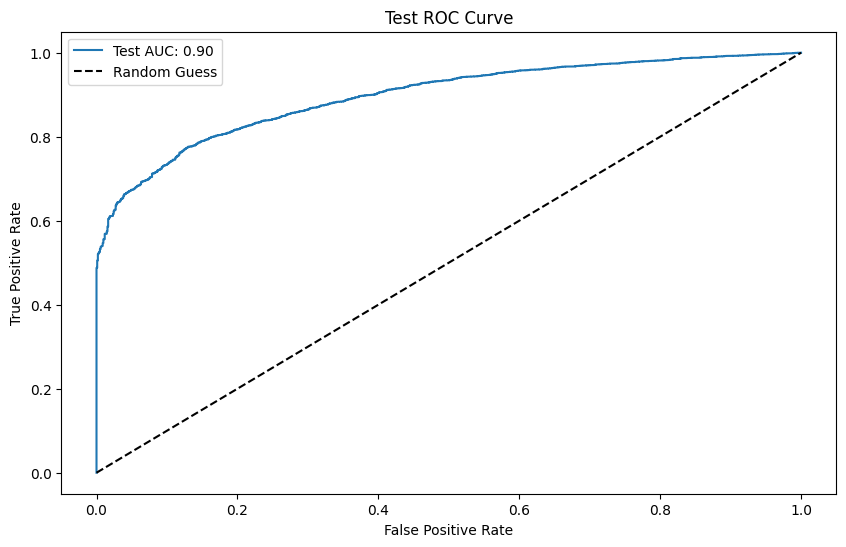

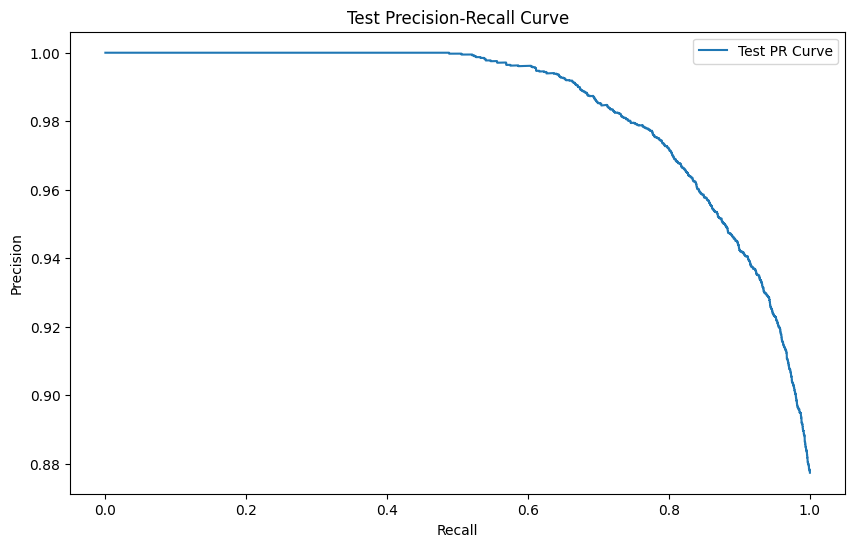


테스트 데이터 Classification Report:
              precision    recall  f1-score   support

           N       0.40      0.77      0.52      1028
           Y       0.96      0.84      0.90      7353

    accuracy                           0.83      8381
   macro avg       0.68      0.80      0.71      8381
weighted avg       0.89      0.83      0.85      8381



In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def calculate_metrics(y_true, y_pred, y_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Y)': precision_score(y_true, y_pred, pos_label='Y'),
        'Recall (Y)': recall_score(y_true, y_pred, pos_label='Y'),
        'F1 (Y)': f1_score(y_true, y_pred, pos_label='Y'),
        'Precision (N)': precision_score(y_true, y_pred, pos_label='N'),
        'Recall (N)': recall_score(y_true, y_pred, pos_label='N'),
        'F1 (N)': f1_score(y_true, y_pred, pos_label='N'),
        'ROC-AUC': roc_auc_score((y_true == 'Y').astype(int), y_proba)
    }

def optimized_cross_validation(model, X, y):
    skf = StratifiedKFold(n_splits=5)
    fold_metrics = []
    class_reports = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx].values, y.iloc[val_idx].values

        best_pipe.fit(X_train_fold, y_train_fold)
        y_pred = best_pipe.predict(X_val_fold)
        y_proba = best_pipe.predict_proba(X_val_fold)[:, 1]

        # 분류 리포트 생성
        report = classification_report(y_val_fold, y_pred, target_names=['N', 'Y'], output_dict=True)

        # 메트릭 수집
        fold_metric = {
            'Fold': fold_idx + 1,
            'N Precision': report['N']['precision'],
            'N Recall': report['N']['recall'],
            'N F1': report['N']['f1-score'],
            'Y Precision': report['Y']['precision'],
            'Y Recall': report['Y']['recall'],
            'Y F1': report['Y']['f1-score'],
            'Accuracy': report['accuracy'],
            'Macro Precision': report['macro avg']['precision'],
            'Macro Recall': report['macro avg']['recall'],
            'Macro F1': report['macro avg']['f1-score'],
            'Weighted Precision': report['weighted avg']['precision'],
            'Weighted Recall': report['weighted avg']['recall'],
            'Weighted F1': report['weighted avg']['f1-score'],
            'Support N': report['N']['support'],
            'Support Y': report['Y']['support']
        }
        fold_metrics.append(fold_metric)

        print(f"\nFold {fold_idx+1} Classification Report:")
        print(classification_report(y_val_fold, y_pred, target_names=['N', 'Y']))

    # 평균값 계산
    avg_metrics = {
        'Fold': 'Average',
        'N Precision': np.mean([m['N Precision'] for m in fold_metrics]),
        'N Recall': np.mean([m['N Recall'] for m in fold_metrics]),
        'N F1': np.mean([m['N F1'] for m in fold_metrics]),
        'Y Precision': np.mean([m['Y Precision'] for m in fold_metrics]),
        'Y Recall': np.mean([m['Y Recall'] for m in fold_metrics]),
        'Y F1': np.mean([m['Y F1'] for m in fold_metrics]),
        'Accuracy': np.mean([m['Accuracy'] for m in fold_metrics]),
        'Macro Precision': np.mean([m['Macro Precision'] for m in fold_metrics]),
        'Macro Recall': np.mean([m['Macro Recall'] for m in fold_metrics]),
        'Macro F1': np.mean([m['Macro F1'] for m in fold_metrics]),
        'Weighted Precision': np.mean([m['Weighted Precision'] for m in fold_metrics]),
        'Weighted Recall': np.mean([m['Weighted Recall'] for m in fold_metrics]),
        'Weighted F1': np.mean([m['Weighted F1'] for m in fold_metrics]),
        'Support N': np.mean([m['Support N'] for m in fold_metrics]),
        'Support Y': np.mean([m['Support Y'] for m in fold_metrics])
    }

    # 결과 테이블 생성
    results_df = pd.DataFrame(fold_metrics + [avg_metrics])
    results_df = results_df.set_index('Fold')

    # 리포트 포맷팅
    print("\n" + "="*50)
    print("교차 검증 최종 결과 (평균값 포함)")
    print(results_df.round(3))
    print("="*50)

    return results_df

# 1. 교차 검증 실행
cv_results = optimized_cross_validation(best_pipe, X_train, y_train)

# 2. 최종 테스트 평가
y_test_pred = best_pipe.predict(X_test)
y_test_pred_proba = best_pipe.predict_proba(X_test)[:, 1]

test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba)
test_df = pd.DataFrame([test_metrics], index=['Test'])

print("\n" + "="*50)
print("최종 테스트 결과:")
print(test_df.round(3))
print("="*50)

# 학습/테스트 성능 비교
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba)


# ROC-AUC 커브 비교
fpr_test, tpr_test, _ = roc_curve((y_test == 'Y').astype(int), y_test_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Test AUC: {roc_auc_score((y_test == "Y").astype(int), y_test_pred_proba):.2f}')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend()
plt.show()

# PR 커브 비교
precision_test, recall_test, _ = precision_recall_curve((y_test == 'Y').astype(int), y_test_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall_test, precision_test, label='Test PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test Precision-Recall Curve')
plt.legend()
plt.show()

# Classification Report (타겟 이름 명시적 지정)

print("\n테스트 데이터 Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['N', 'Y']))
